# Combatting Partisan Homogenization in New Content Recommenders - Baselines(BERT)

In [1]:
# to do
# test with our prototypes and our actual topic labelled data
# use immigration and guns topic, prototypes have to have differing stance variation

## Table of Contents 
### [Clustering Documents, Filtering and Vectorization](#Clustering_Documents_Filtering_Vectorization)
### [Baseline 1 - (Cluster Similarity vs Model Performance)](#Cluster_Similarity_vs_Model_Performance)
### [Baseline 2 - (Online Setting Performance)](#Online_Setting_Performance)
### [Baseline 3 - (Single Cluster Online Setting Performance)](#Single_Cluster_Online_Setting_Performance)
### [Baseline 4 - (Regularization vs Online Setting Performance)](#Regularization_vs_Online_Setting_Performance)
### [Baseline 5 - (Learning Rate vs Online Setting Performance)](#Learning_Rate_vs_Online_Setting_Performance)
### [Baseline 6 - (Online Setting Mixed Data Performance)](#Online_Setting_Mixed_Data_Performance)
### [Baseline 7 - (Learning Rate vs Online Setting Mixed Data Performance)](#Learning_Rate_vs_Online_Setting_Mixed_Data_Performance)

#### Important:
* Heterogenous User:
    * Conservative on Cluster 1 but Liberal on Cluster 2
* Homogeneous User:
    * Conservative on Cluster 1 and Cluster 2

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

In [4]:
from general_utils import timer

from config import RANDOM_SEED

from bert_utils import load_bert_output

from preprocess_utils import preprocess_texts, tfidf_vectorization, dimensionality_reduction

from clustering_utils import run_clustering, get_cluster_sizes, score_cluster, get_cluster_pairs, get_pairwise_dist, cluster2doc, filter_clusters, get_top_100_clusterpairs

from data_utils import load_data, sample_data, balanced_sampling, create_train_test

from metrics_utils import calculate_avg_precision, calculate_map, get_scores, get_scores_wot, calculate_avg_precision_param_variation, calculate_map_param_variation

from model_utils import ( run_model, 
                         run_bs1_train_all, 
                         run_online_setting_active, 
                         run_bs2_train_all, 
                         run_bs3_train_all, 
                         run_bs4_train_all, 
                         run_bs5_train_all, 
                         run_bs6_train_all, 
                         run_bs7_train_all)

from plotters_baseline import ( plot_size_dist, 
                               bsl1_sim_vs_score_all_users, 
                               regularization_plot_helper, 
                               plot_regularization_vs_metrics_at_k, 
                               combine_scores_reg_vs_metrics_at_k, 
                               plot_regularization_vs_metrics_at_k_cumu, 
                               plot_lr_vs_metrics_at_k, 
                               plot_lr_vs_metrics_at_k_cumu, 
                               plot_online_setting_per_clusterpair, 
                               plot_helper_all_cp, 
                               plot_all_cp_online, 
                               plot_all_cp_singlecluster, 
                               plot_helper_scp, 
                               plot_single_cluster_performance, 
                               plot_mixed_data_all_cp_perf, 
                               plot_helper_md, 
                               plot_prec_sep, 
                               plot_mixed_data_performance_per_cluster, 
                               plot_mixed_data_performance, 
                               combine_scores_cumu_online_setting,
                               plot_mixed_cluster_cumulative, 
                               plot_online_learning_cumulative, 
                               plot_single_cluster_cumulative, 
                               plot_mixed_data_all_cp_perf, 
                               lr_mixed_plot_helper, 
                               plot_lr_vs_metrics_at_k_mixed, 
                               plot_mixed_data_all_cp_precis_lr, 
                               plot_mixed_cluster_cumulative_per_cluster  )   

....... Initializing Settings ..... 
Random_Seed Chosen : 15112


In [5]:
warnings.filterwarnings('ignore')

In [6]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.grid'] = True

# Main Components

1) Data Loading  
2) Sampling  
3) Text Preprocessing  
4) Vectorization  
5) Dimensionality Reductions  
6) Clustering  
7) Clustering Performance Check  
8) Cluster Filtering  
9) Pairwise Selection  
10) Model Training and Performance  
11) Pairwise score analysis  

## Clustering Documents, Filtering and Vectorization <a class="anchor" id="Clustering_Documents_Filtering_Vectorization"></a>

Index(['article_id', 'url', 'title', 'text', 'source', 'source_partisan_score',
       'tweet_id', 'tweet_screen_name', 'tweet_created_at', 'tweet_text'],
      dtype='object')
Df original shape : (921037, 10)
Df shape after dropping nan text : (919430, 10)
Df shape after dropping duplicate articles based on title : (912084, 10)
Df shape after dropping 0 stance articles : (630425, 10)

Finished running 'load_data' in 0.4334 mins


Finished running 'sample_data' in 0.0016 mins

Sampled Size: 100000
Running : select_first10
Running : to_lower
Running : remove_punc
Running : remove_small_words
Running : remove_spaces

Finished running 'preprocess_texts' in 0.3202 mins

First Ten Files : ['/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/0.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/1.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/2.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_outputs/3.npy', '/media/karthikshivaram/Extra_disk_1/Bert_model_ou

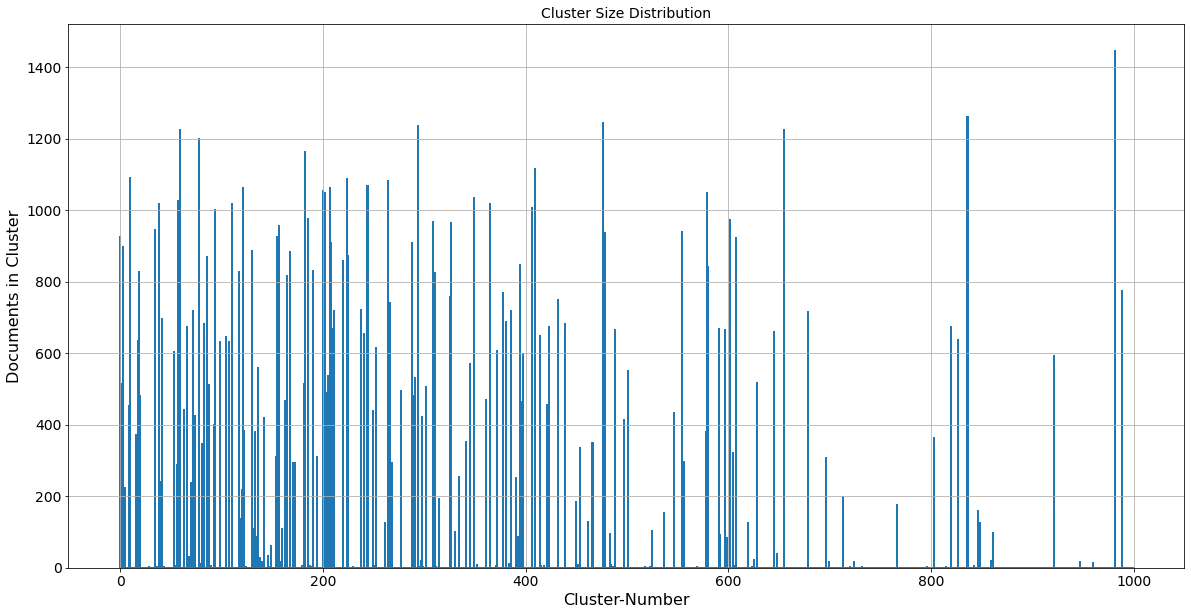


Finished running 'get_pairwise_dist' in 0.0002 mins


Number of Cluster Pairs : 499500

Finished running 'get_cluster_pairs' in 0.0021 mins

499500


In [7]:
path = "../articles.csv"

main_df = load_data(path)

sampled_df = sample_data(df=main_df,sample_size=100000,seed=RANDOM_SEED)
print("Sampled Size: %s" %str(sampled_df.shape[0]))

sampled_df["processed_text"] = preprocess_texts(text_lists=sampled_df["text"])

reduced_vectors =  load_bert_output(folder1="/media/karthikshivaram/Extra_disk_1/Bert_model_outputs",
                              folder2="/media/karthikshivaram/Extra_Disk_2/Bert_model_outputs",
                              layer=12,aggregation="mean + max")

print("Bert Embedding Output Shape : %s" %str(reduced_vectors.shape))

clusters,cluster_clf = run_clustering(vectors=reduced_vectors,seed=RANDOM_SEED,num_clusters=1000,clus_type="kmeans")

cluster_sizes = get_cluster_sizes(cluster_clf)

plot_size_dist(cluster_sizes)

cluster_pair_dist_mat = get_pairwise_dist(cluster_clf,dist_type="cosine")

cluster_pairs = get_cluster_pairs(num_clusters=1000)
print(len(cluster_pairs))

In [8]:
doc_2_cluster_map = cluster2doc(num_texts=sampled_df.shape[0],cluster_labels=cluster_clf.labels_)


Finished running 'cluster2doc' in 0.0005 mins



In [9]:
filtered_cluster_pairs = filter_clusters(cluster_pairs=cluster_pairs,
                                        doc_2_cluster_map=doc_2_cluster_map,
                                        cluster_sizes=cluster_sizes,
                                        partisan_scores=sampled_df["binary_ps"].tolist(),
                                        min_size=450,
                                        max_size=5000,
                                        min_partisan_size=0.4)

print("Filtered CLustered Pairs : %s" %str(len(filtered_cluster_pairs)))


Finished running 'filter_clusters' in 0.0965 mins

Filtered CLustered Pairs : 1485


In [10]:
top100 = get_top_100_clusterpairs(cluster_pairs=filtered_cluster_pairs,dist_matrix=cluster_pair_dist_mat,reverse=True)


Finished running 'get_top_100_clusterpairs' in 0.0000 mins



## Baseline 1 : <a class="anchor" id="Cluster_Similarity_vs_Model_Performance"></a>

In [11]:
df_result = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Heterogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0457 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.1062 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0275 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0831 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0274 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0883 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0839 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0378 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0963 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0752 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0384 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0272 mins

Training model

In [12]:
df_result_homog = run_bs1_train_all(X = reduced_vectors,
                          cluster_2_doc_map = doc_2_cluster_map ,
                          df = sampled_df ,
                          cluster_pairs = top100,
                          cosine_mat = cluster_pair_dist_mat,
                          thresholds = [0.5,0.7,0.9],
                          user_type="Homogeneous")

Training model for cluster pair : 0

Finished running 'run_model' in 0.0454 mins

Training model for cluster pair : 1

Finished running 'run_model' in 0.0962 mins

Training model for cluster pair : 2

Finished running 'run_model' in 0.0343 mins

Training model for cluster pair : 3

Finished running 'run_model' in 0.0864 mins

Training model for cluster pair : 4

Finished running 'run_model' in 0.0228 mins

Training model for cluster pair : 5

Finished running 'run_model' in 0.0611 mins

Training model for cluster pair : 6

Finished running 'run_model' in 0.0834 mins

Training model for cluster pair : 7

Finished running 'run_model' in 0.0405 mins

Training model for cluster pair : 8

Finished running 'run_model' in 0.0816 mins

Training model for cluster pair : 9

Finished running 'run_model' in 0.0652 mins

Training model for cluster pair : 10

Finished running 'run_model' in 0.0453 mins

Training model for cluster pair : 11

Finished running 'run_model' in 0.0225 mins

Training model

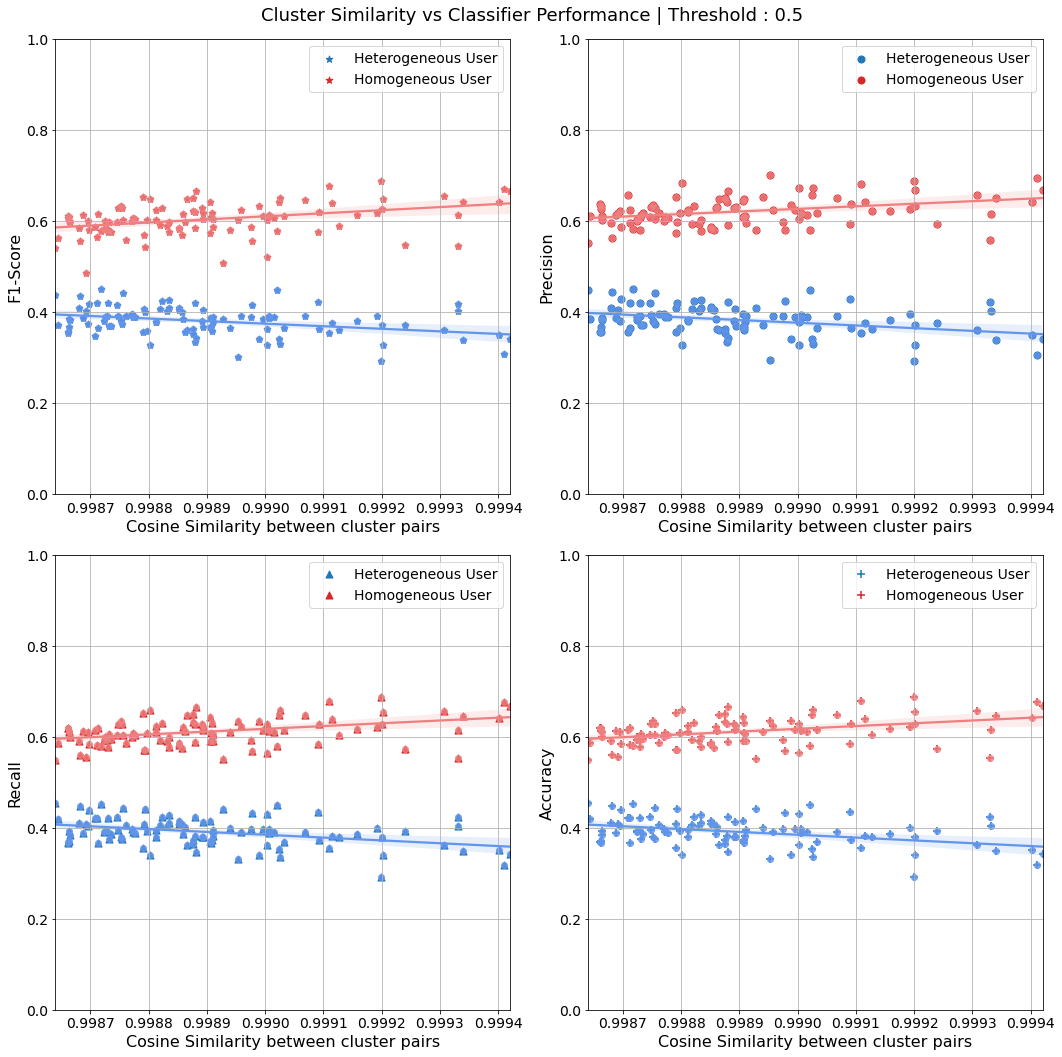


Finished running 'bsl1_sim_vs_score_all_users' in 0.0218 mins



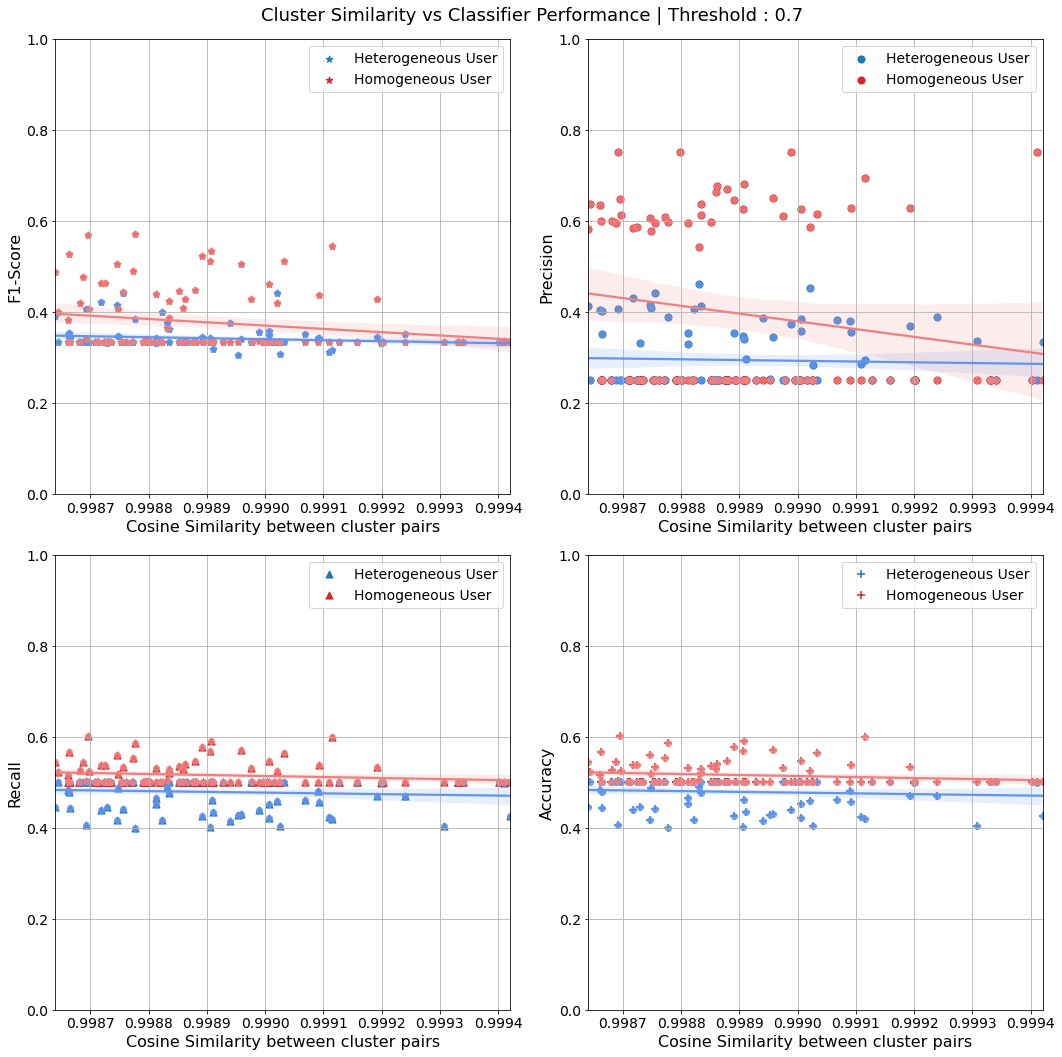


Finished running 'bsl1_sim_vs_score_all_users' in 0.0211 mins



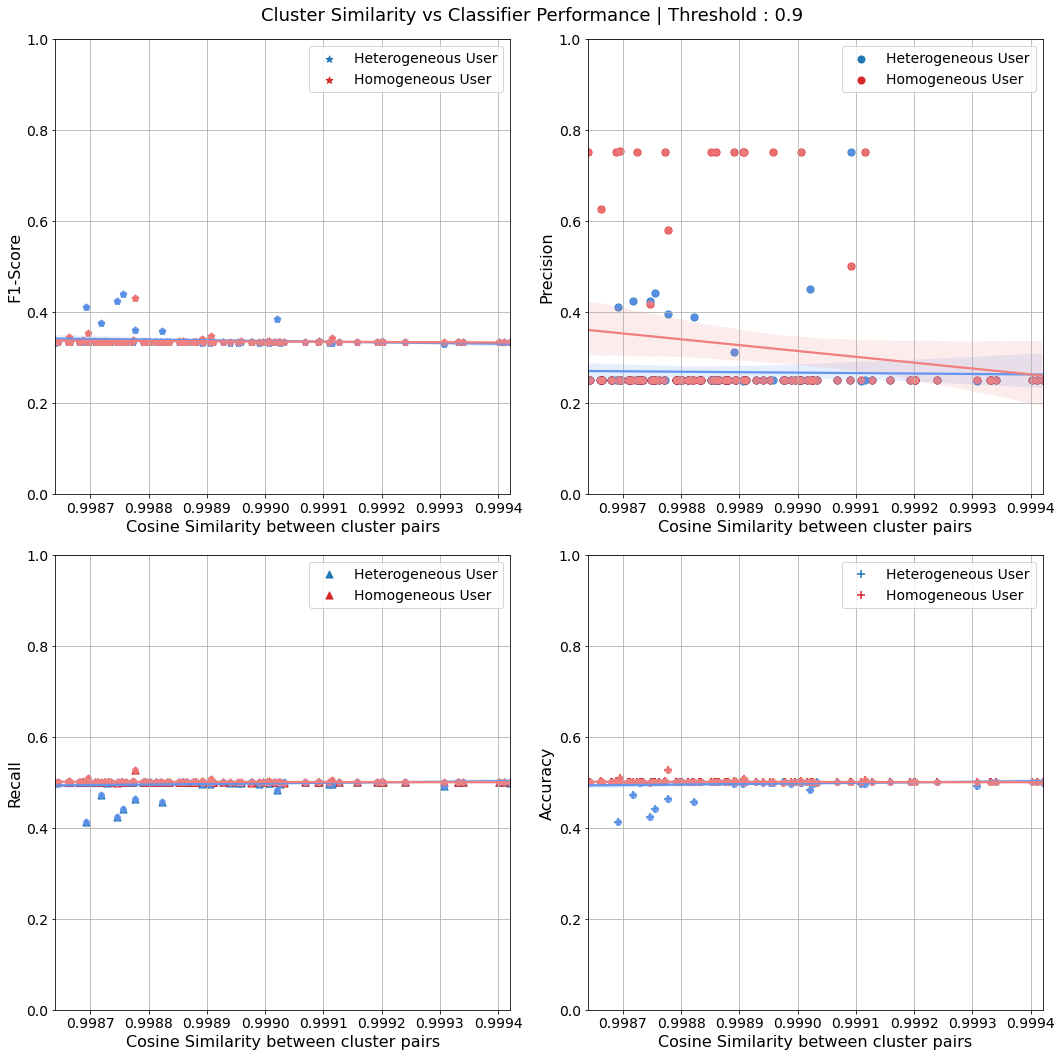


Finished running 'bsl1_sim_vs_score_all_users' in 0.0214 mins



In [13]:
for threshold in [0.5,0.7,0.9]:
    bsl1_sim_vs_score_all_users(df_results_hetero=df_result,
                                df_results_homo=df_result_homog,
                                threshold=threshold)

<!-- ## Online Learning Setting - Active Learning Setting (Performance Measured on Held Out Validation Dataset) -->

## Baseline 2 : <a class="anchor" id="Online_Setting_Performance"></a>

In [14]:
hetero_scores,df_res_map_hetero = run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : (488, 608)
Training model for cluster pair : (655, 982)
Training model for cluster pair : (414, 608)
Training model for cluster pair : (224, 326)
Training model for cluster pair : (53, 294)
Training model for cluster pair : (38, 224)
Training model for cluster pair : (78, 554)
Training model for cluster pair : (185, 679)
Training model for cluster pair : (182, 207)
Training model for cluster pair : (78, 244)
Training model for cluster pair : (185, 488)
Training model for cluster pair : (58, 110)
Training model for cluster pair : (121, 244)
Training model for cluster pair : (645, 679)
Training model for cluster pair : (185, 645)
Training model for cluster pair : (311, 597)
Training model for cluster pair : (244, 294)
Training model for cluster pair : (579, 827)
Training model for cluster pair : (208, 211)
Training model for cluster pair : (394, 579)
Training model for cluster pair : (185, 608)
Training model for cluster pair : (57, 165)
Training model f

In [15]:
homo_scores, df_res_map_homo =  run_bs2_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : (488, 608)
Training model for cluster pair : (655, 982)
Training model for cluster pair : (414, 608)
Training model for cluster pair : (224, 326)
Training model for cluster pair : (53, 294)
Training model for cluster pair : (38, 224)
Training model for cluster pair : (78, 554)
Training model for cluster pair : (185, 679)
Training model for cluster pair : (182, 207)
Training model for cluster pair : (78, 244)
Training model for cluster pair : (185, 488)
Training model for cluster pair : (58, 110)
Training model for cluster pair : (121, 244)
Training model for cluster pair : (645, 679)
Training model for cluster pair : (185, 645)
Training model for cluster pair : (311, 597)
Training model for cluster pair : (244, 294)
Training model for cluster pair : (579, 827)
Training model for cluster pair : (208, 211)
Training model for cluster pair : (394, 579)
Training model for cluster pair : (185, 608)
Training model for cluster pair : (57, 165)
Training model f


Finished running 'combine_scores_cumu_online_setting' in 0.0001 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



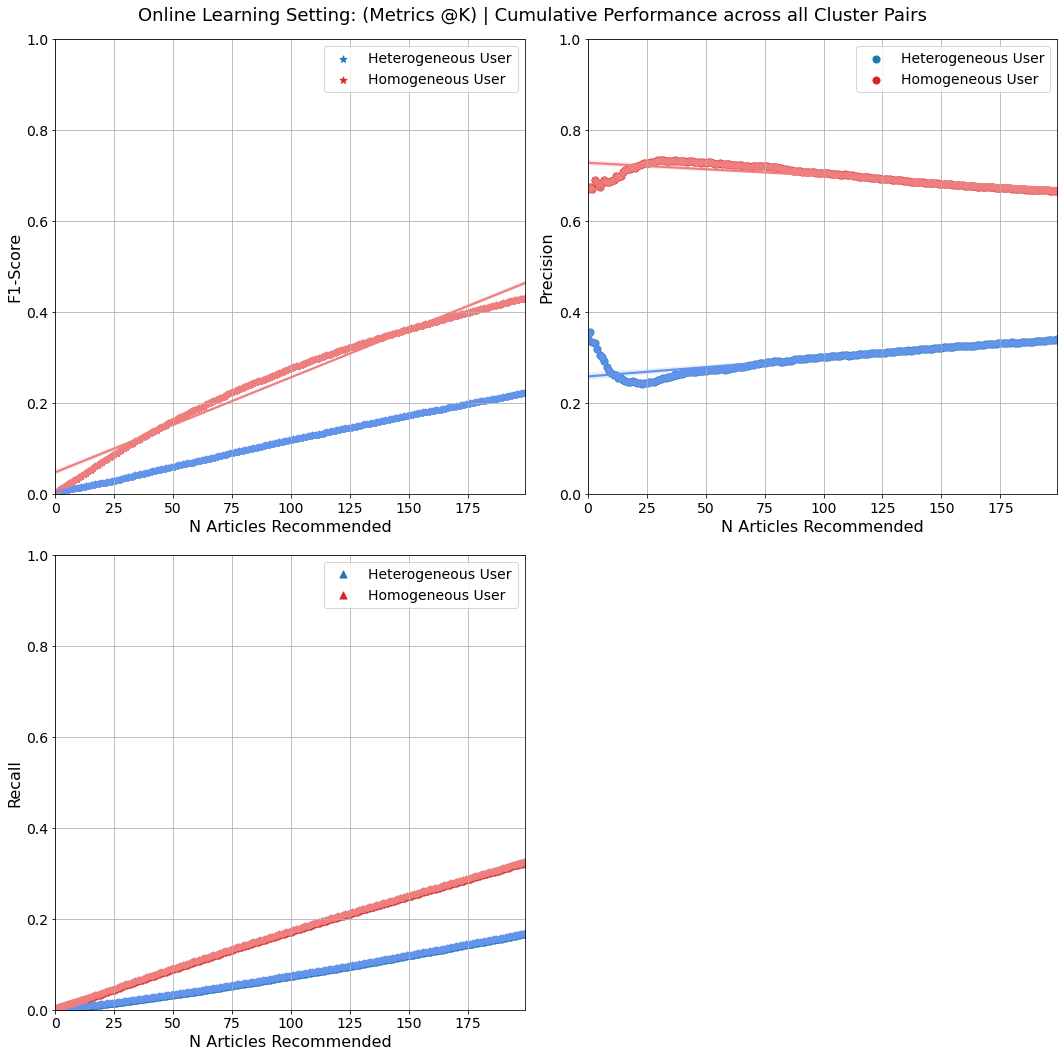


Finished running 'plot_online_setting_per_clusterpair' in 0.0182 mins


Finished running 'plot_online_learning_cumulative' in 0.0183 mins



In [16]:
plot_online_learning_cumulative(homo_scores,hetero_scores,active=False)

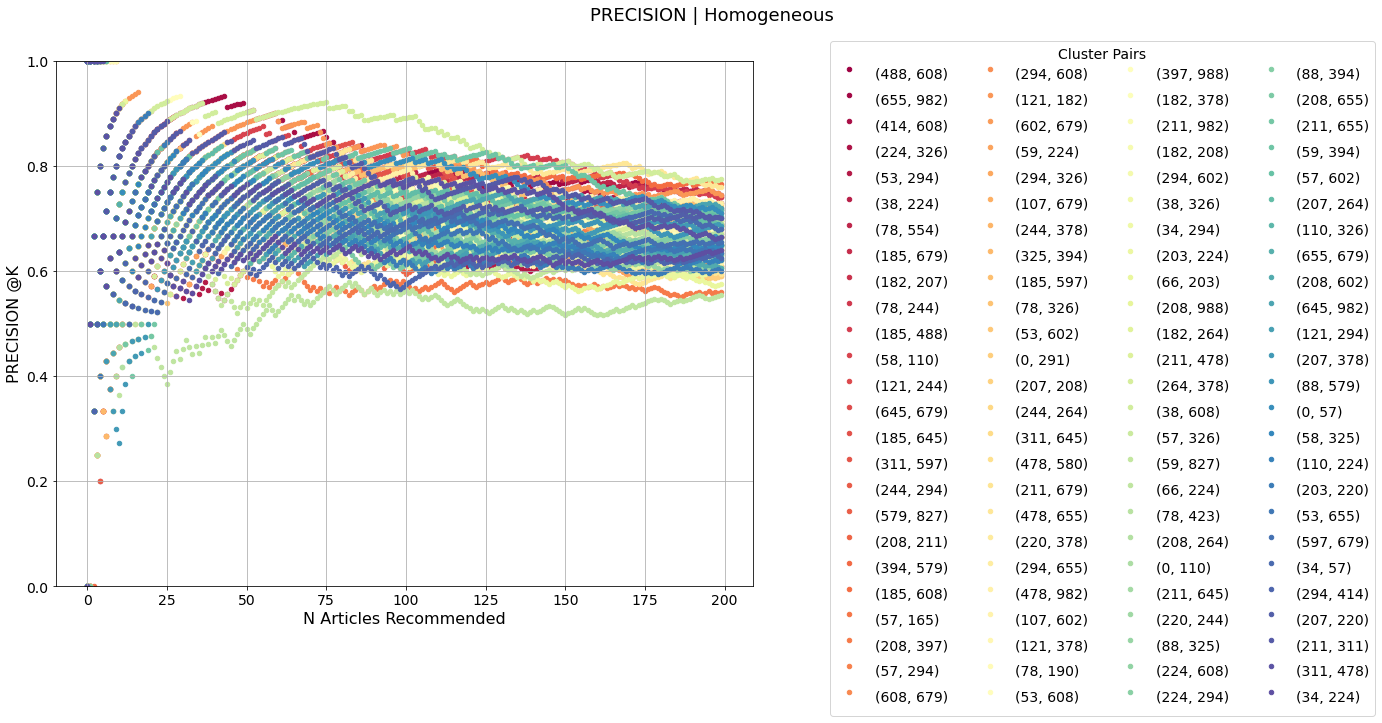


Finished running 'plot_all_cp_online' in 0.0615 mins



In [17]:
plot_all_cp_online(homo_scores,user_type="Homogeneous",metric="precision")

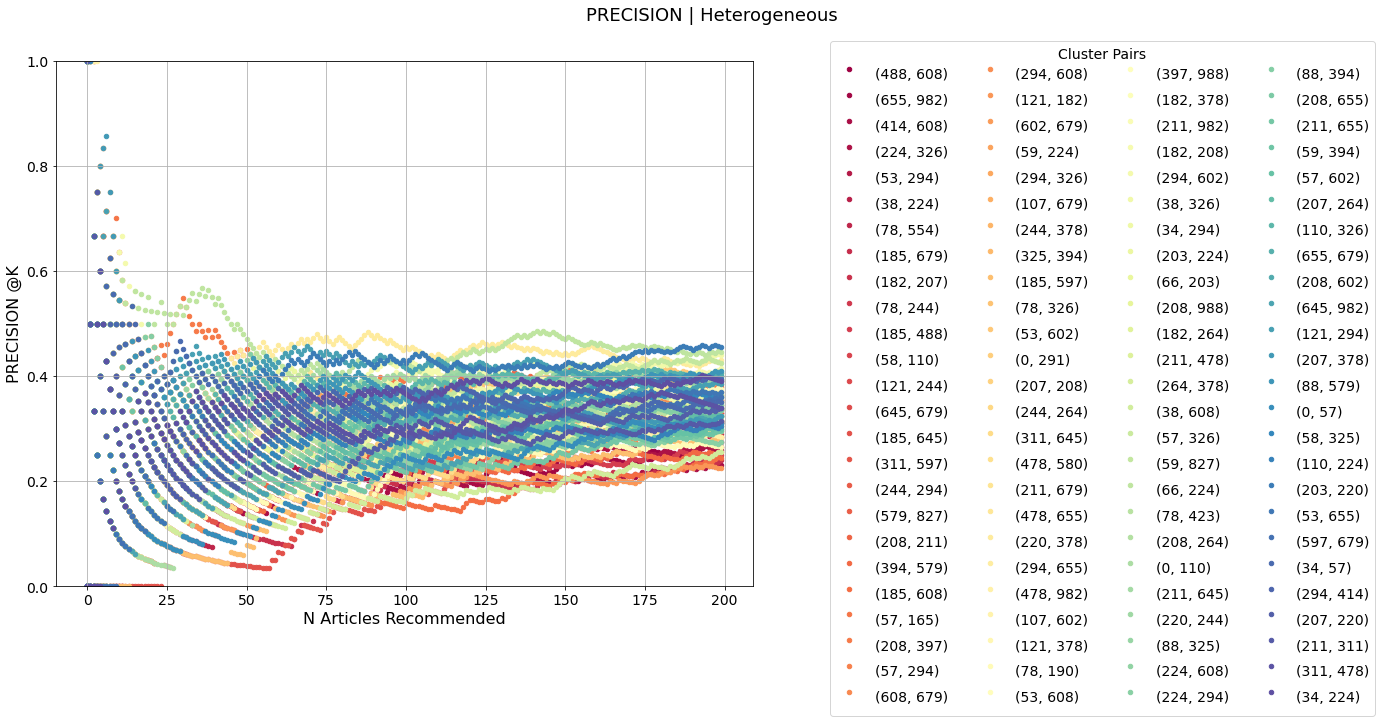


Finished running 'plot_all_cp_online' in 0.0633 mins



In [18]:
plot_all_cp_online(hetero_scores,user_type="Heterogeneous",metric="precision")

In [19]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [20]:
np.mean(avg_presc_homo)

0.6993120609892105

In [21]:
avg_presc_hetero = calculate_avg_precision(hetero_scores,mode="single")

In [22]:
np.mean(avg_presc_hetero)

0.29846600037591586

## Baseline 3 :  <a class="anchor" id="Single_Cluster_Online_Setting_Performance"></a>

In [23]:
hetero_scores = run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [24]:
homo_scores =  run_bs3_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                   user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins


Finished running 'combine_scores_cumu_online_setting' in 0.0000 mins



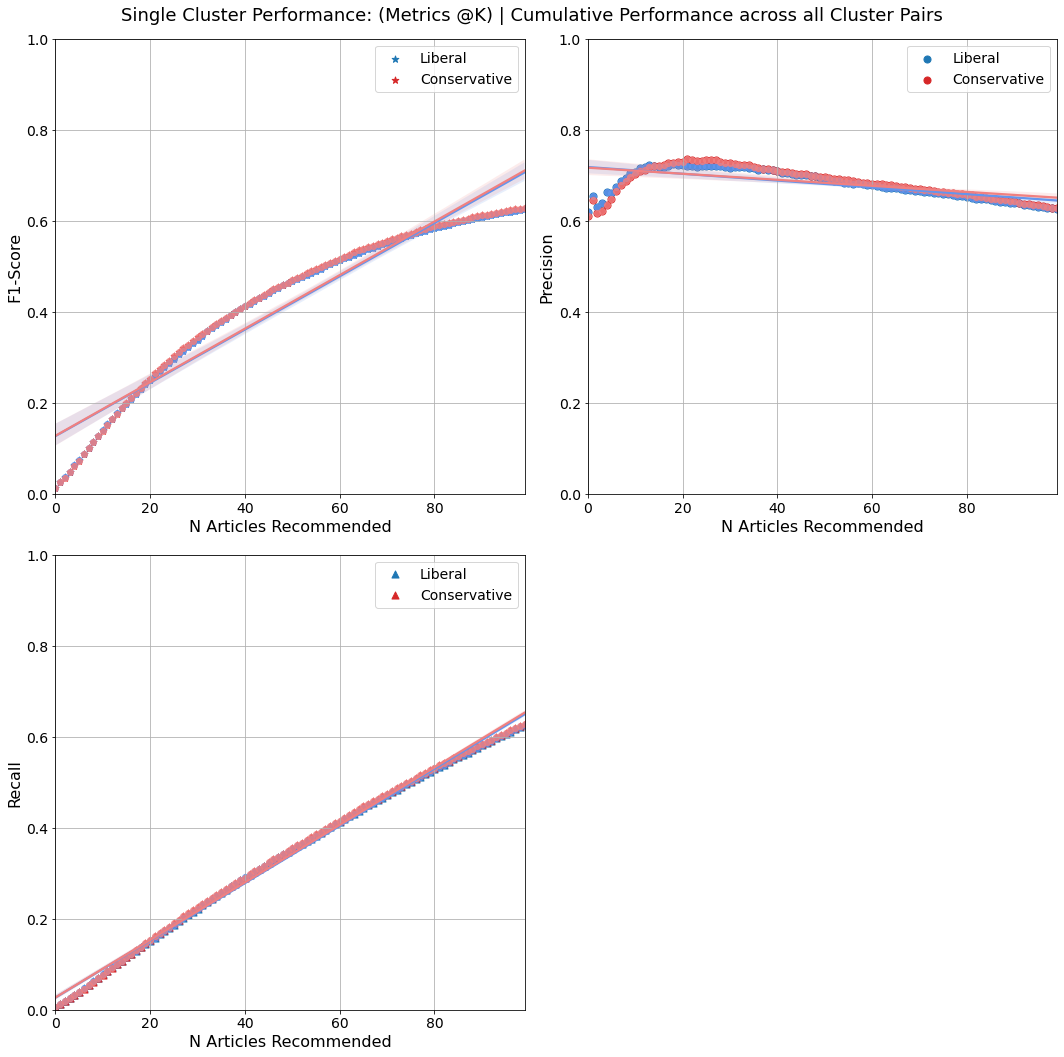


Finished running 'plot_single_cluster_performance' in 0.0164 mins


Finished running 'plot_single_cluster_cumulative' in 0.0165 mins



In [25]:
plot_single_cluster_cumulative(homo_scores,hetero_scores)

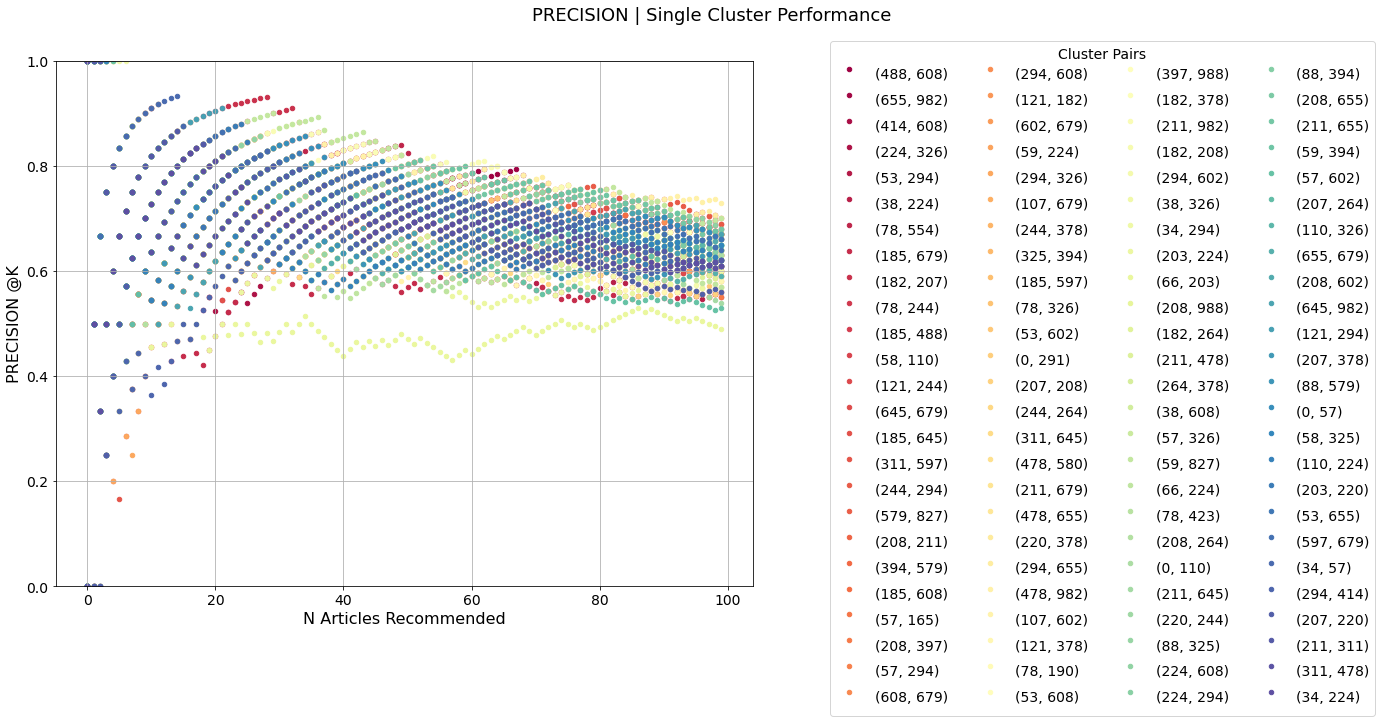


Finished running 'plot_all_cp_singlecluster' in 0.0564 mins



In [26]:
plot_all_cp_singlecluster(homo_scores)

In [27]:
avg_presc_homo = calculate_avg_precision(homo_scores,mode="single")

In [28]:
np.mean(avg_presc_homo)

0.6836887618154642

## Baseline 4: <a class="anchor" id="Regularization_vs_Online_Setting_Performance"></a>

In [29]:
hetero_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [30]:
homo_scores = run_bs4_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 reg_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



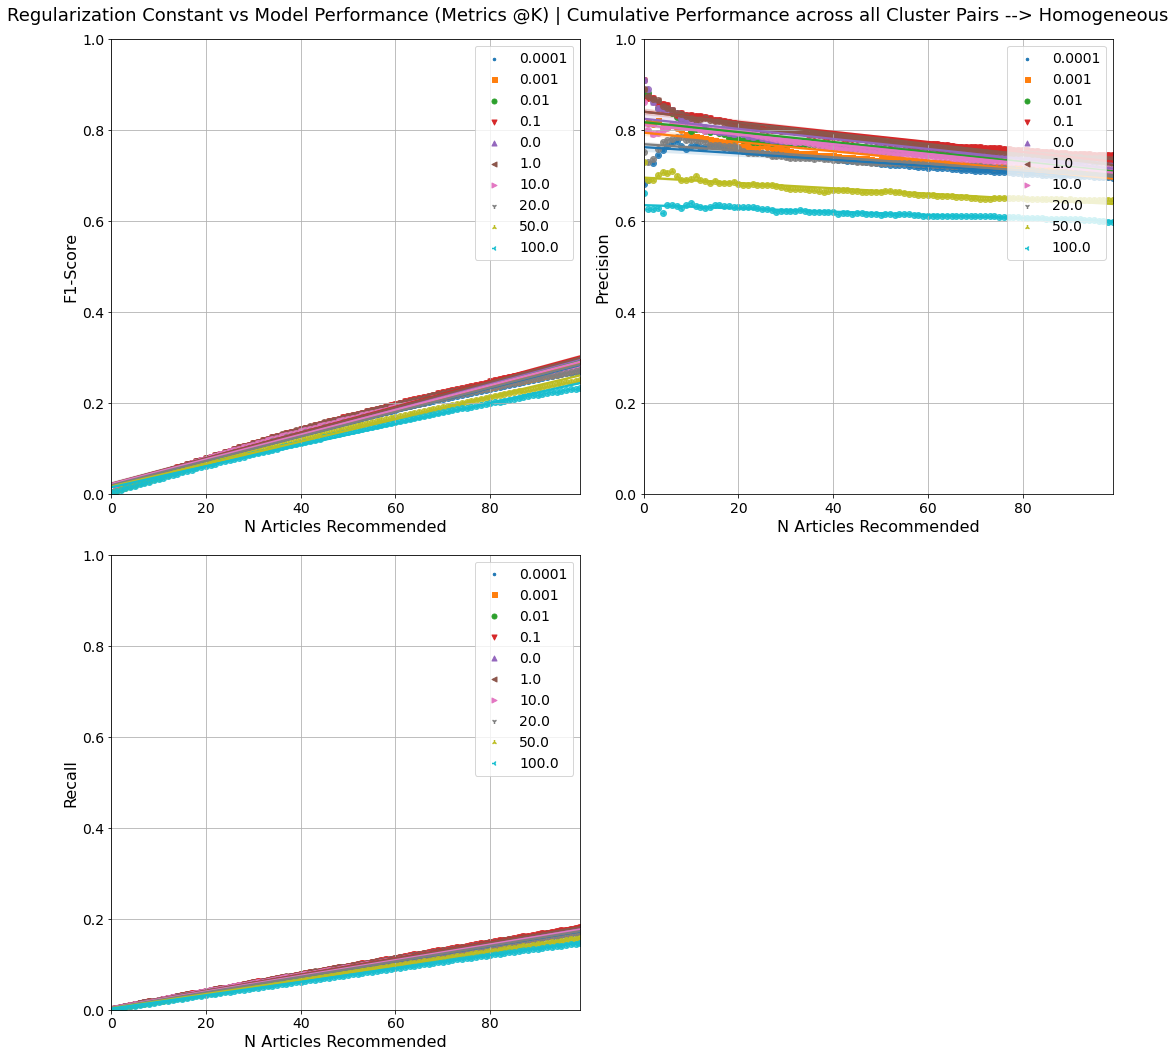


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0594 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0597 mins



In [31]:
plot_regularization_vs_metrics_at_k_cumu(homo_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0],
                                         user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0003 mins



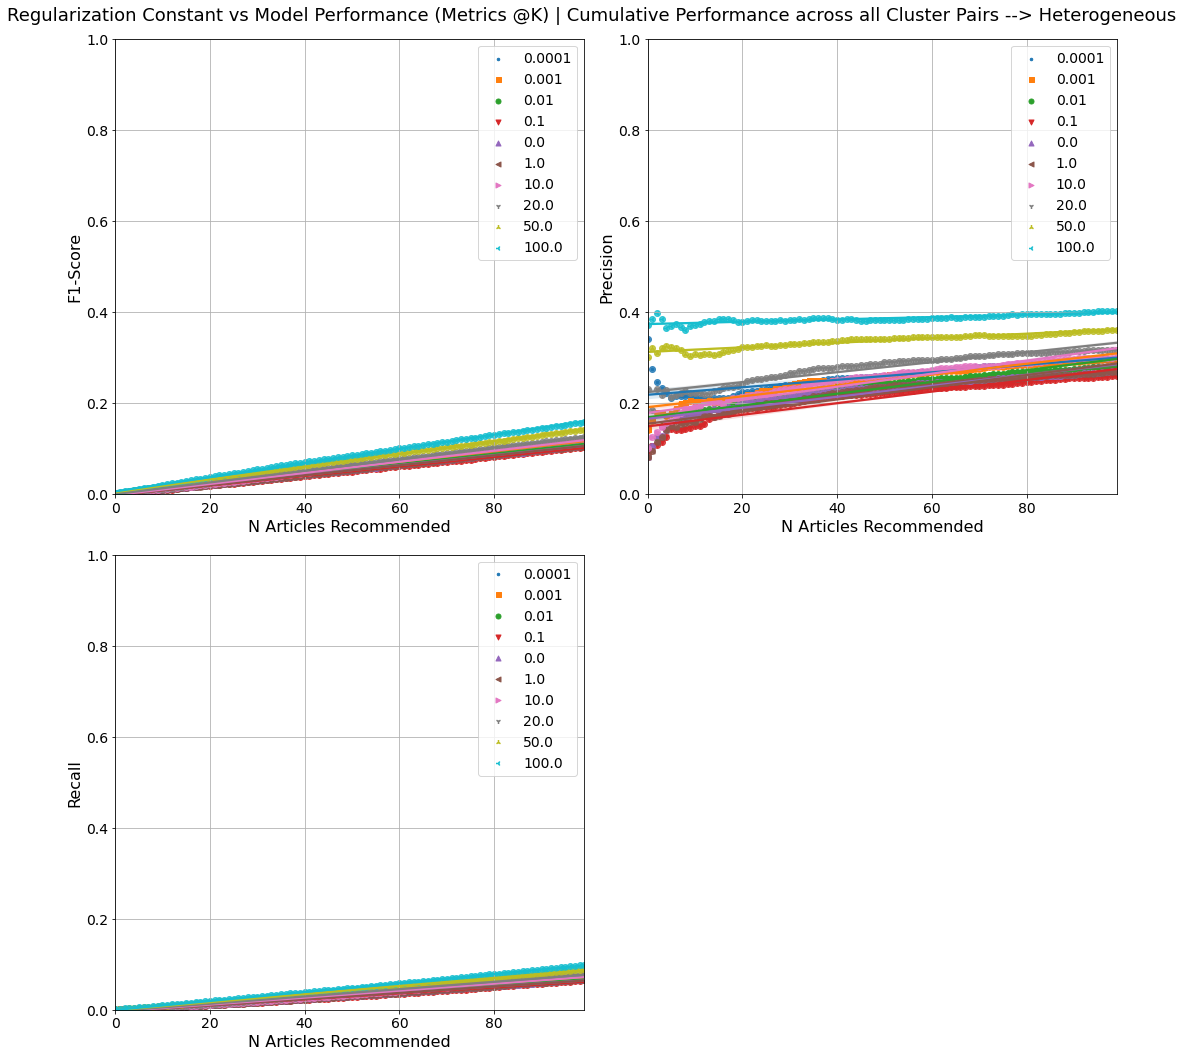


Finished running 'plot_regularization_vs_metrics_at_k' in 0.0590 mins


Finished running 'plot_regularization_vs_metrics_at_k_cumu' in 0.0593 mins



In [32]:
plot_regularization_vs_metrics_at_k_cumu(hetero_scores,
                                         regularization_constants=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [33]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [34]:
calculate_map_param_variation(homo_param_res)


Param : 0.0001
0.7274742375309539

Param : 0.001
0.7430061177465969

Param : 0.01
0.7627240656487777

Param : 0.1
0.7848287057495226

Param : 0.0
0.7693680923798896

Param : 1.0
0.7811802826438072

Param : 10.0
0.7580750994318665

Param : 20.0
0.7327143036857465

Param : 50.0
0.6657656936686845

Param : 100.0
0.6166661987855017


In [35]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.0001,0.001,0.01,0.1,0.0,1.0,10.0,20.0,50.0,100.0])

In [36]:
calculate_map_param_variation(hetero_param_res)


Param : 0.0001
0.2584979513615714

Param : 0.001
0.24954415591298648

Param : 0.01
0.2323772867230735

Param : 0.1
0.211387009918202

Param : 0.0
0.22474916444548942

Param : 1.0
0.22030893743302016

Param : 10.0
0.24901432057292233

Param : 20.0
0.27781155455767503

Param : 50.0
0.33672570423262504

Param : 100.0
0.38577585675938875


## Baseline 5 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Performance"></a>

In [37]:
hetero_scores,df_het_res_100,df_het_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (488, 608) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (488, 608) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (488, 608) , LR = 20 *****

In [38]:
homo_scores,df_hom_res_100,df_hom_res_500 = run_bs5_train_all(X=reduced_vectors,sample_df=sampled_df,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0

*************** CP = (488, 608) , LR = 0.001 ****************
SGDClassifier(eta0=0.001, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 0.01 ****************
SGDClassifier(eta0=0.01, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 0.1 ****************
SGDClassifier(eta0=0.1, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 1.0 ****************
SGDClassifier(eta0=1.0, learning_rate='constant', loss='log',
              random_state=15112)

*************** CP = (488, 608) , LR = 10 ****************
SGDClassifier(eta0=10, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (488, 608) , LR = 15 ****************
SGDClassifier(eta0=15, learning_rate='constant', loss='log', random_state=15112)

*************** CP = (488, 608) , LR = 20 *****


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0005 mins



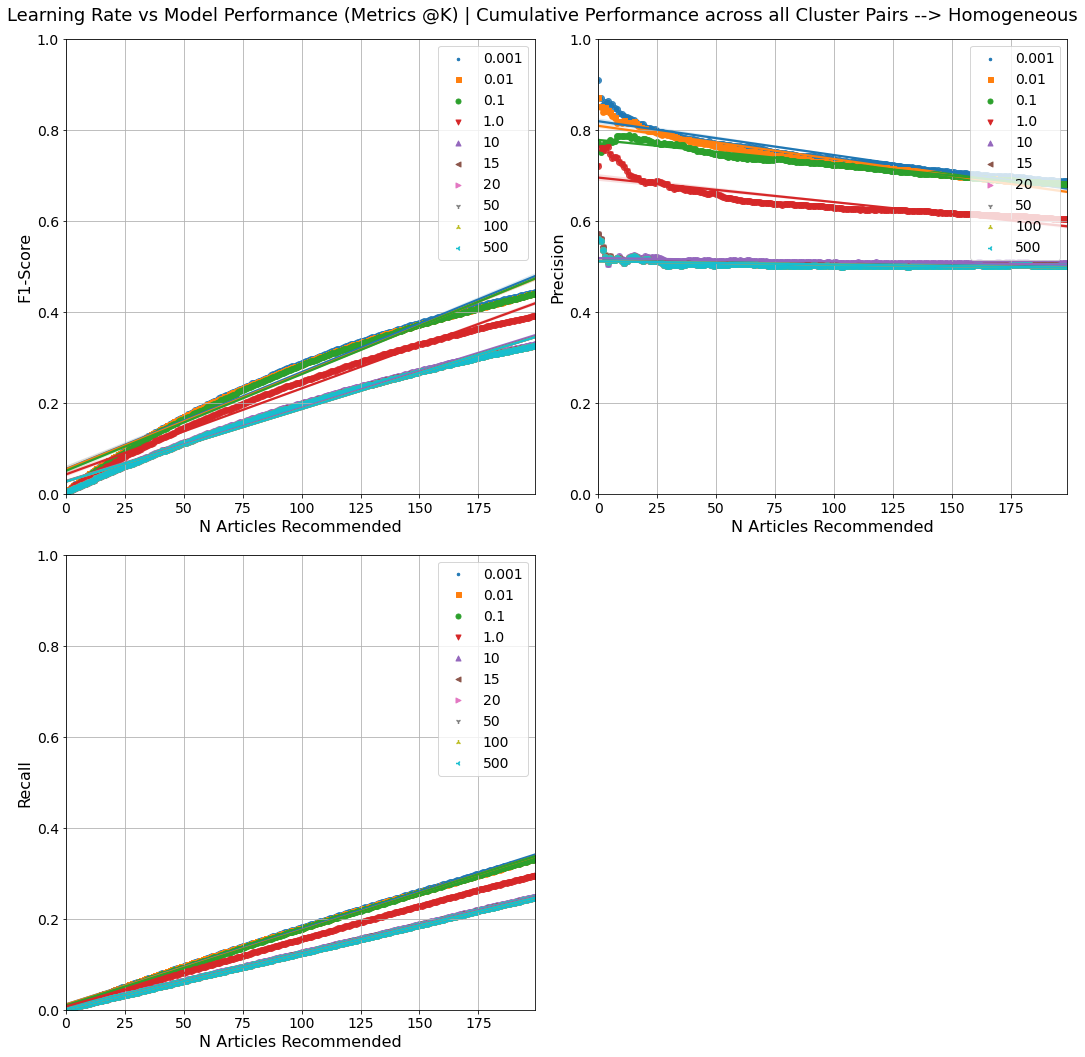


Finished running 'plot_lr_vs_metrics_at_k' in 0.0651 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0656 mins



In [39]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous")


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



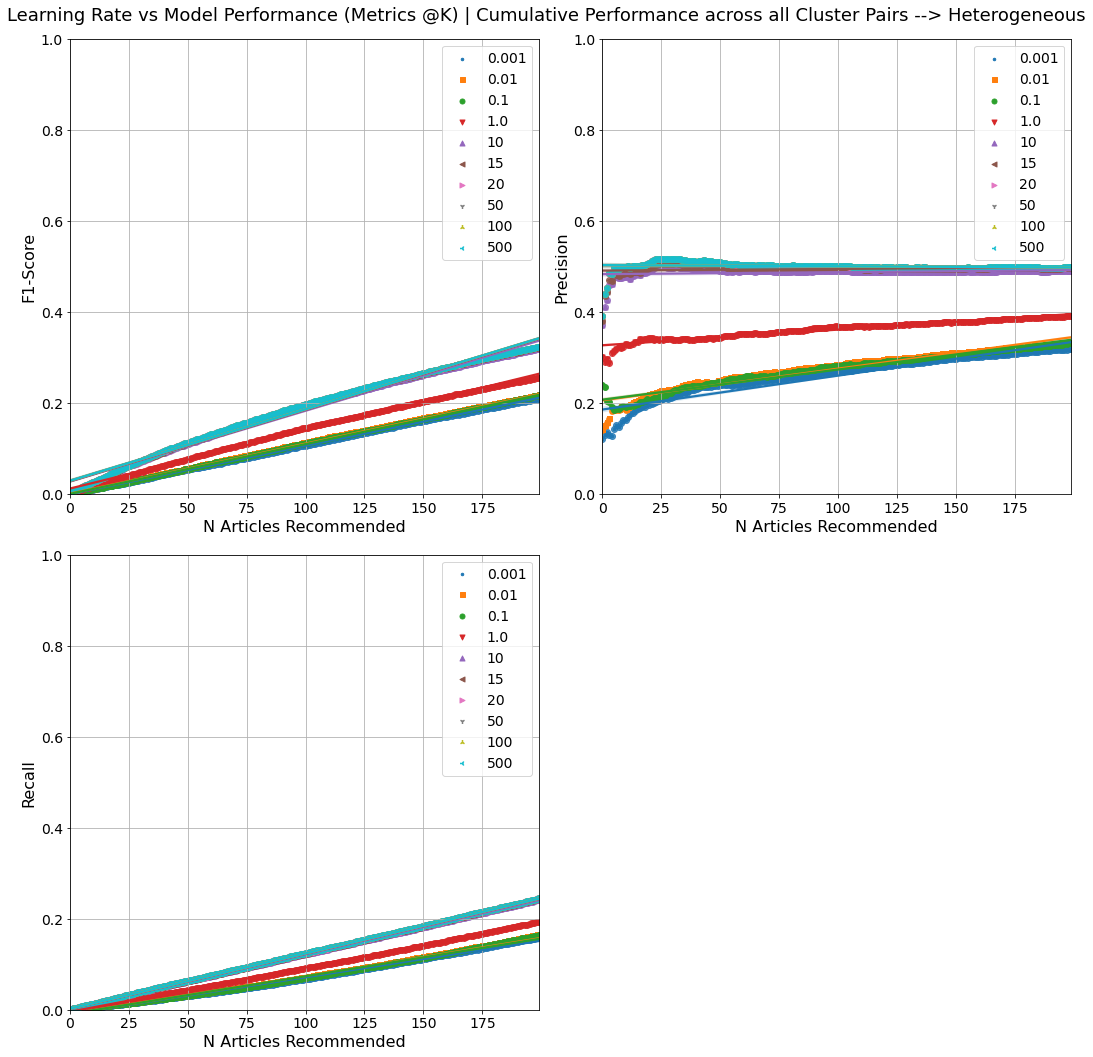


Finished running 'plot_lr_vs_metrics_at_k' in 0.0648 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0654 mins



In [40]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [41]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [42]:
calculate_map_param_variation(homo_param_res)


Param : 0.001
0.7446411473397232

Param : 0.01
0.7359332536224359

Param : 0.1
0.7257372789176451

Param : 1.0
0.6412840800285253

Param : 10
0.5108894141351601

Param : 15
0.5048587657800307

Param : 20
0.5039394728213555

Param : 50
0.5039394728213555

Param : 100
0.5039394728213555

Param : 500
0.5039394728213555


In [43]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

In [44]:
calculate_map_param_variation(hetero_param_res)


Param : 0.001
0.25941625793805306

Param : 0.01
0.27483312801749676

Param : 0.1
0.272848659943542

Param : 1.0
0.3607455215341767

Param : 10
0.4870609908883767

Param : 15
0.49417519393509346

Param : 20
0.499754029888633

Param : 50
0.5000202194911718

Param : 100
0.5000202194911718

Param : 500
0.5000202194911718


## Baseline 6: <a class="anchor" id="Online_Setting_Mixed_Data_Performance"></a>

In [45]:
hetero_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [46]:
homo_scores = run_bs6_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous")

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [47]:
# homo_scores.keys()

In [48]:
# plot_mixed_data_performance_per_cluster(homo_scores[(585, 712)],hetero_scores[(585, 712)])


Finished running 'combine_scores_mixed_data' in 0.0002 mins


Finished running 'combine_scores_mixed_data' in 0.0002 mins



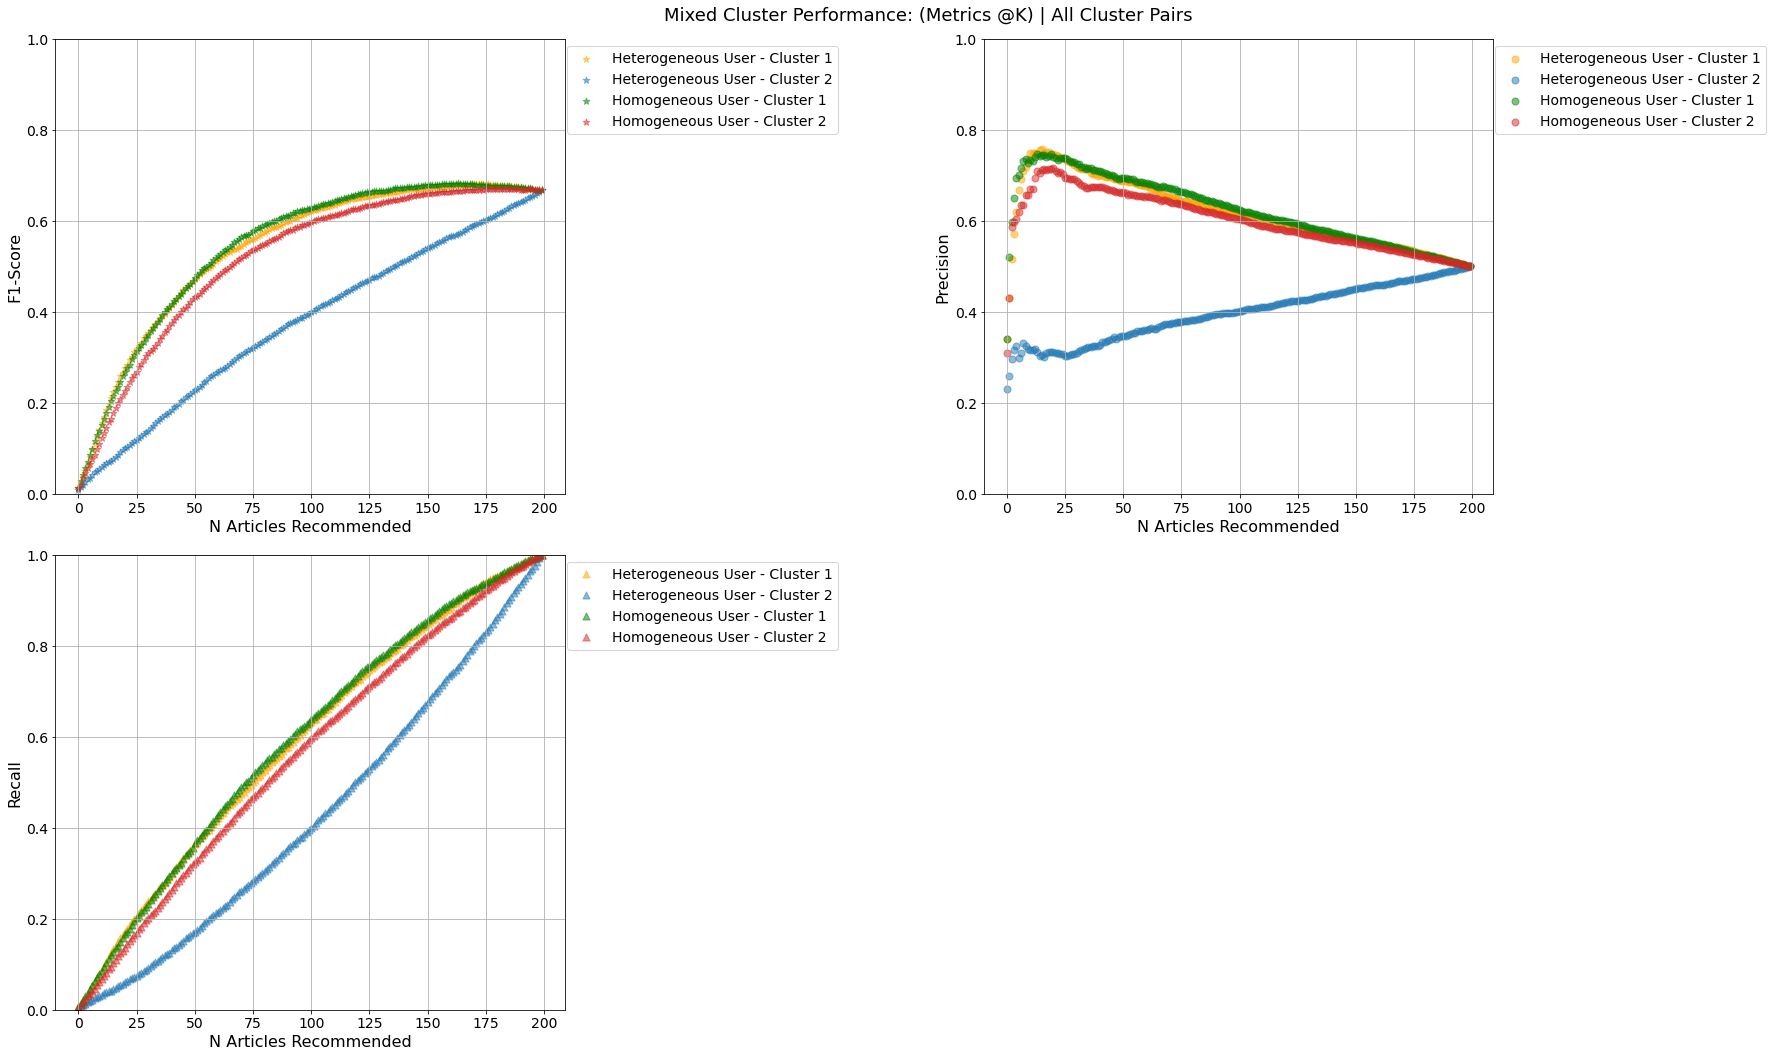


Finished running 'plot_mixed_data_performance_per_cluster' in 0.0104 mins


Finished running 'plot_mixed_cluster_cumulative_per_cluster' in 0.0107 mins



In [49]:
plot_mixed_cluster_cumulative_per_cluster(homo_scores,hetero_scores)

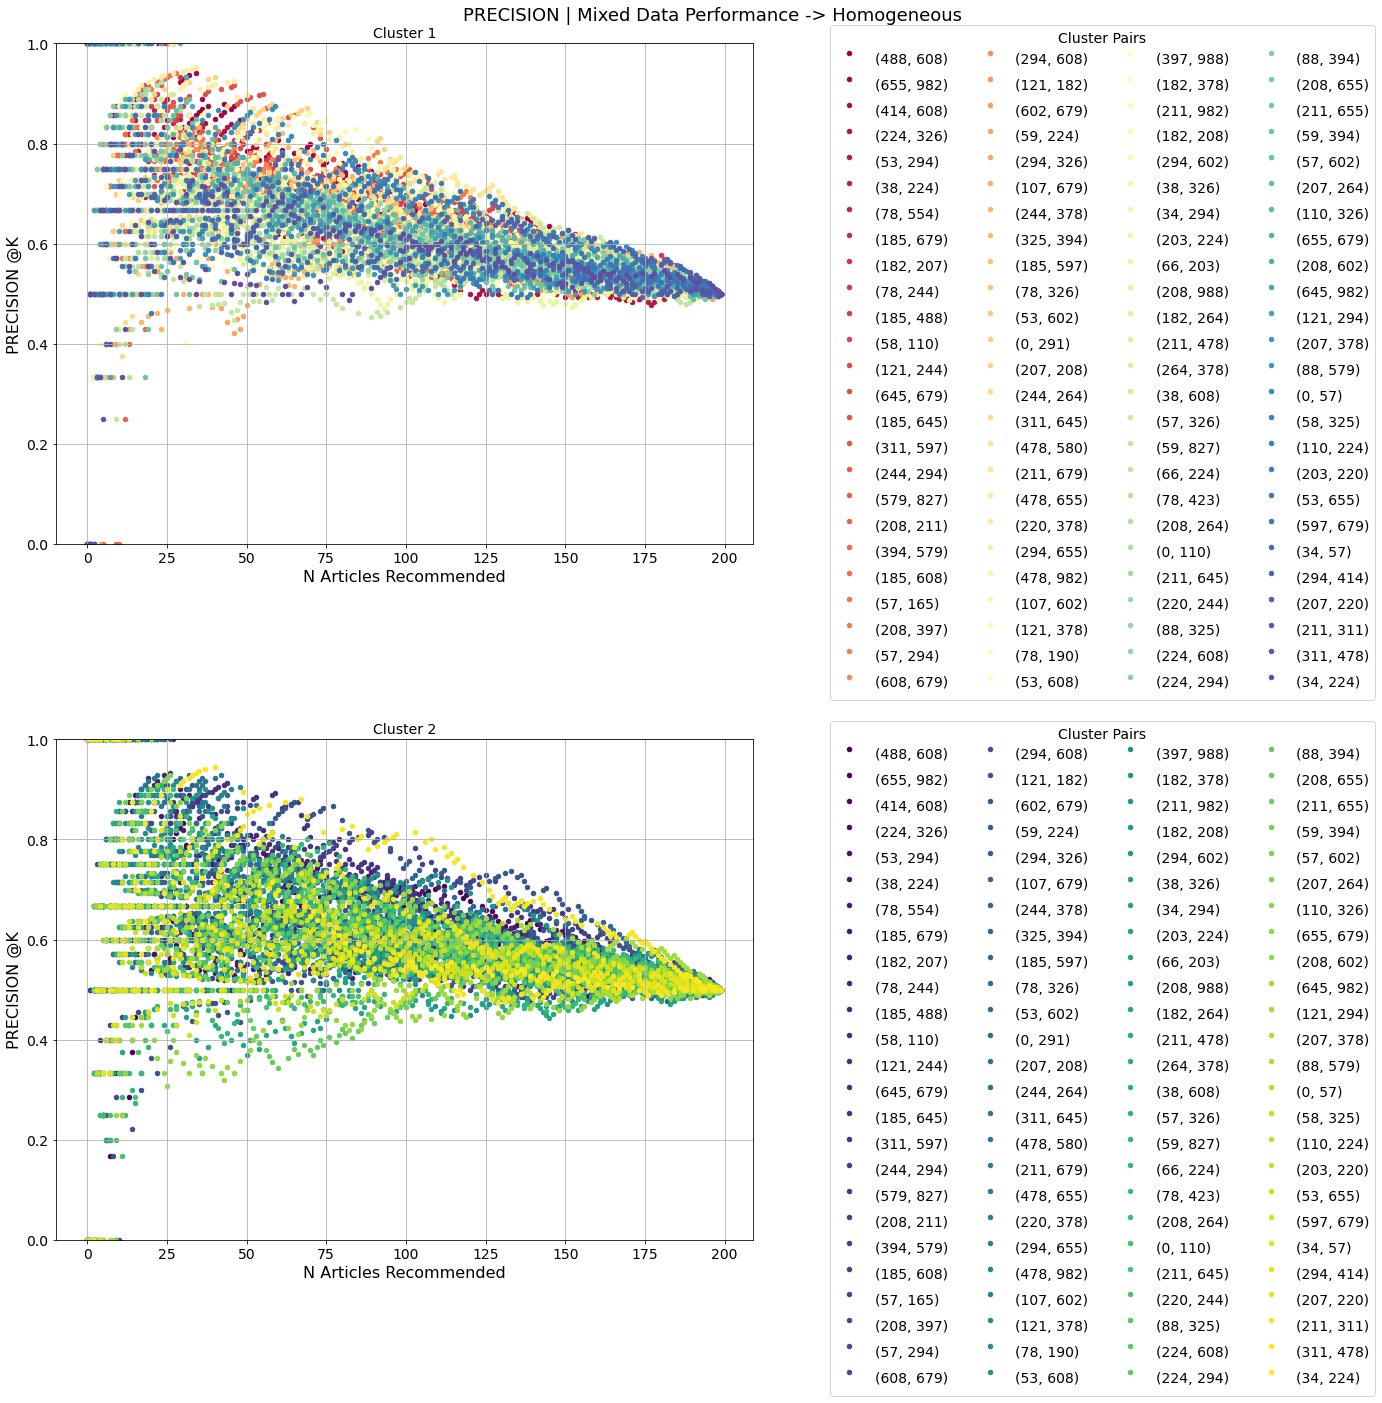


Finished running 'plot_mixed_data_all_cp_perf' in 0.1162 mins



In [50]:
plot_mixed_data_all_cp_perf(scores_cp=homo_scores,user_type="Homogeneous",metric="precision")

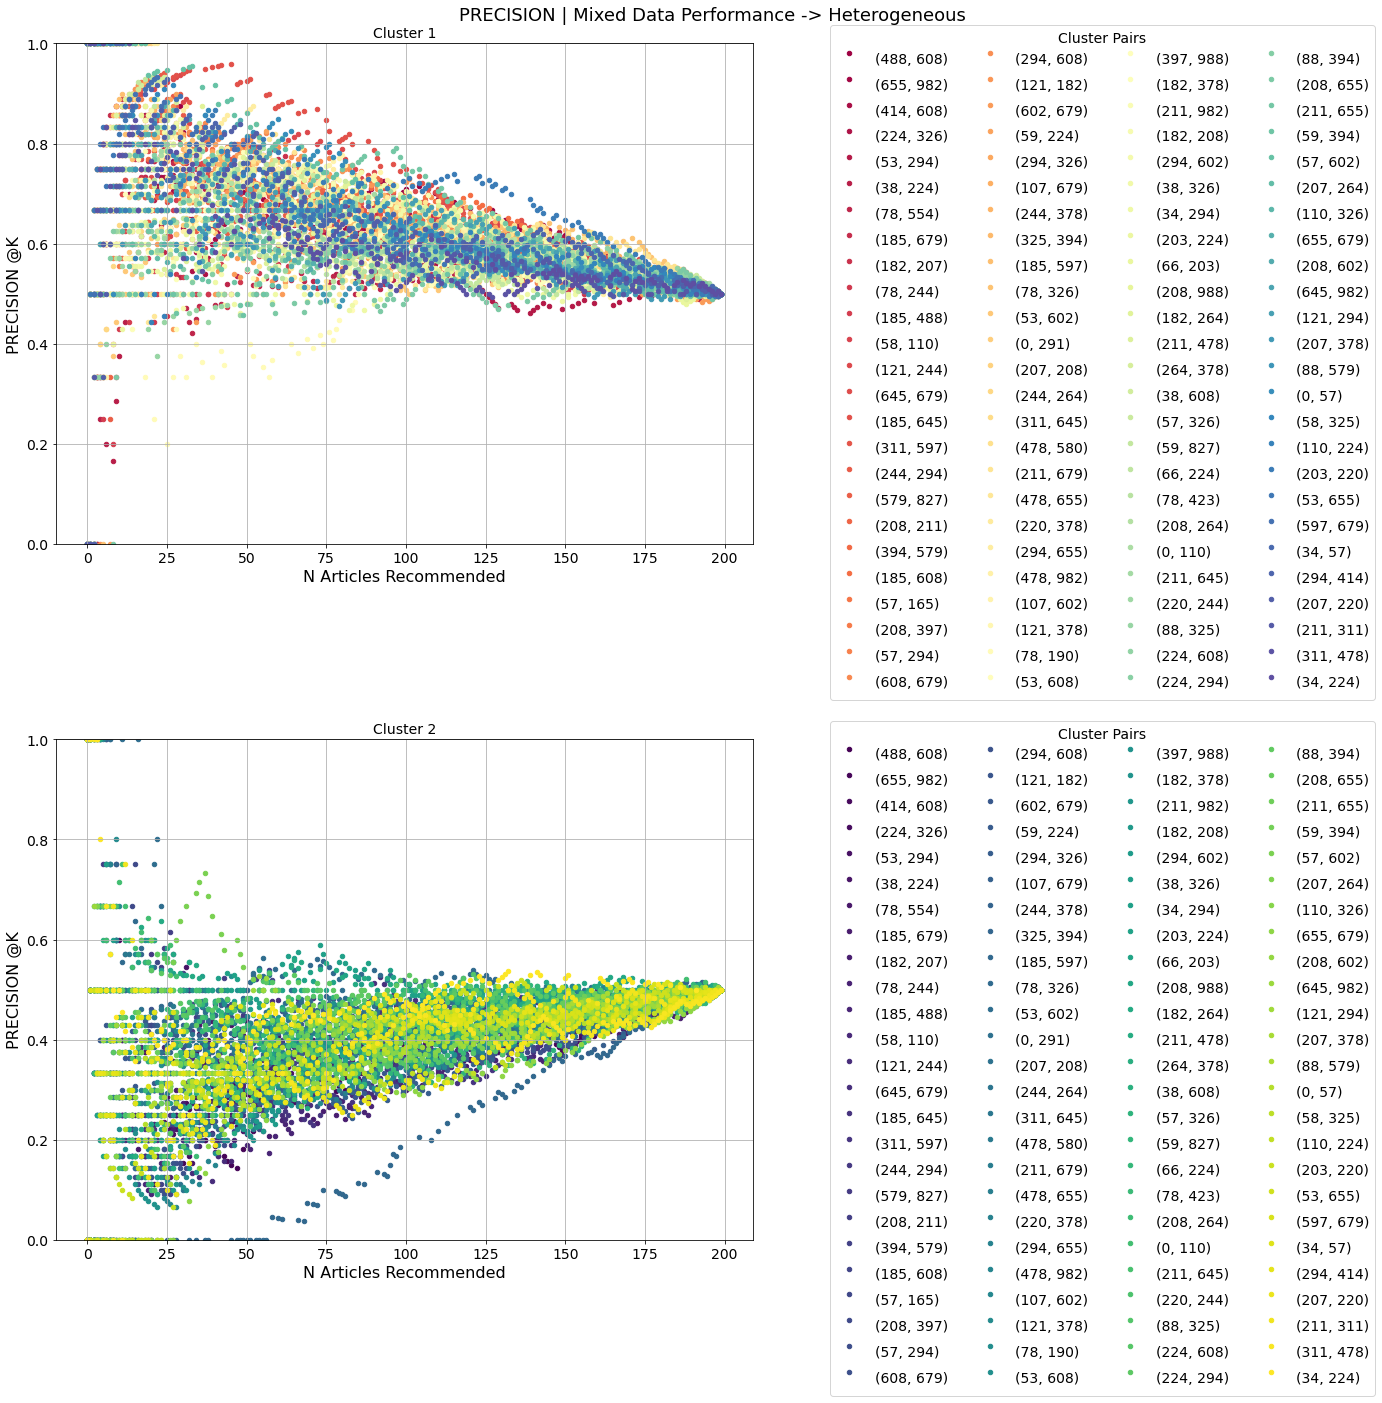


Finished running 'plot_mixed_data_all_cp_perf' in 0.1177 mins



In [51]:
plot_mixed_data_all_cp_perf(scores_cp=hetero_scores,user_type="Heterogeneous",metric="precision")

In [52]:
avg_presc_homo, avg_presc_homo_c1, avg_presc_homo_c2 = calculate_avg_precision(homo_scores,mode="mixed")

In [53]:
np.mean(avg_presc_homo)

0.6127910146737764

In [54]:
np.mean(avg_presc_homo_c1)

0.6234544904650366

In [55]:
np.mean(avg_presc_homo_c2)

0.5998836395865614

In [56]:
avg_presc_hetero, avg_presc_hetero_c1, avg_presc_hetero_c2 = calculate_avg_precision(hetero_scores,mode="mixed")

In [57]:
np.mean(avg_presc_hetero)

0.5153219707568562

In [58]:
np.mean(avg_presc_hetero_c1)

0.6164179834140636

In [59]:
np.mean(avg_presc_hetero_c2)

0.39731672152671055

## Baseline 7 : <a class="anchor" id="Learning_Rate_vs_Online_Setting_Mixed_Data_Performance"></a>

In [60]:
hetero_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Heterogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [61]:
homo_scores = run_bs7_train_all(X=reduced_vectors,
                                   cluster_2_doc_map=doc_2_cluster_map,
                                   df=sampled_df,
                                   cluster_pairs=top100,
                                   cosine_mat=cluster_pair_dist_mat,
                                 user_type="Homogeneous",
                                 lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])

Training model for cluster pair : 0
Training model for cluster pair : 1
Training model for cluster pair : 2
Training model for cluster pair : 3
Training model for cluster pair : 4
Training model for cluster pair : 5
Training model for cluster pair : 6
Training model for cluster pair : 7
Training model for cluster pair : 8
Training model for cluster pair : 9
Training model for cluster pair : 10
Training model for cluster pair : 11
Training model for cluster pair : 12
Training model for cluster pair : 13
Training model for cluster pair : 14
Training model for cluster pair : 15
Training model for cluster pair : 16
Training model for cluster pair : 17
Training model for cluster pair : 18
Training model for cluster pair : 19
Training model for cluster pair : 20
Training model for cluster pair : 21
Training model for cluster pair : 22
Training model for cluster pair : 23
Training model for cluster pair : 24
Training model for cluster pair : 25
Training model for cluster pair : 26
Training mo

In [62]:
# plot_lr_vs_metrics_at_k_mixed(homo_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],user_type="Homogeneous")

In [63]:
# plot_lr_vs_metrics_at_k_mixed(hetero_scores[(585, 712)],
#                                     lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500])


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0006 mins



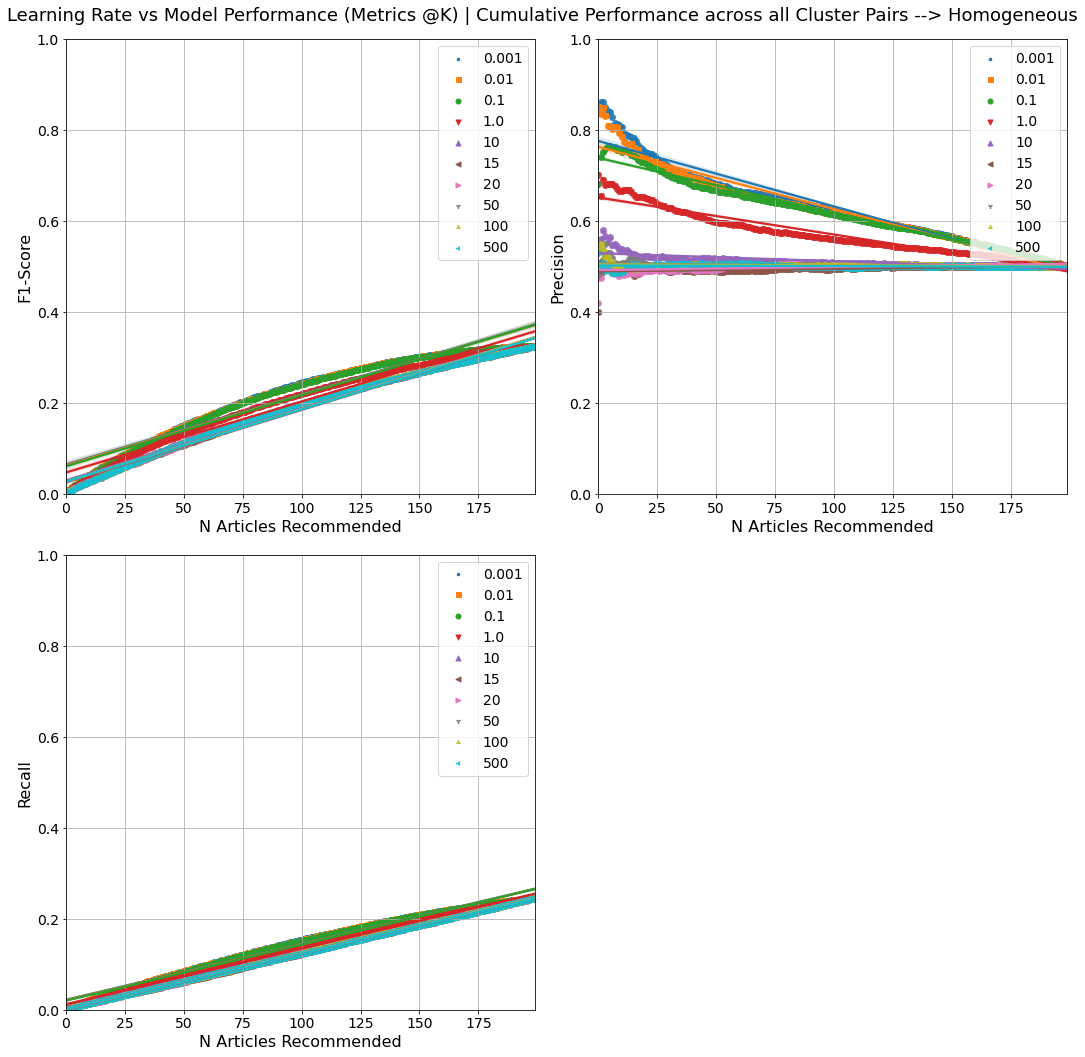


Finished running 'plot_lr_vs_metrics_at_k' in 0.0658 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0664 mins



In [64]:
plot_lr_vs_metrics_at_k_cumu(homo_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
                             user_type="Homogeneous",mixed_data=True)


Finished running 'combine_scores_reg_vs_metrics_at_k' in 0.0007 mins



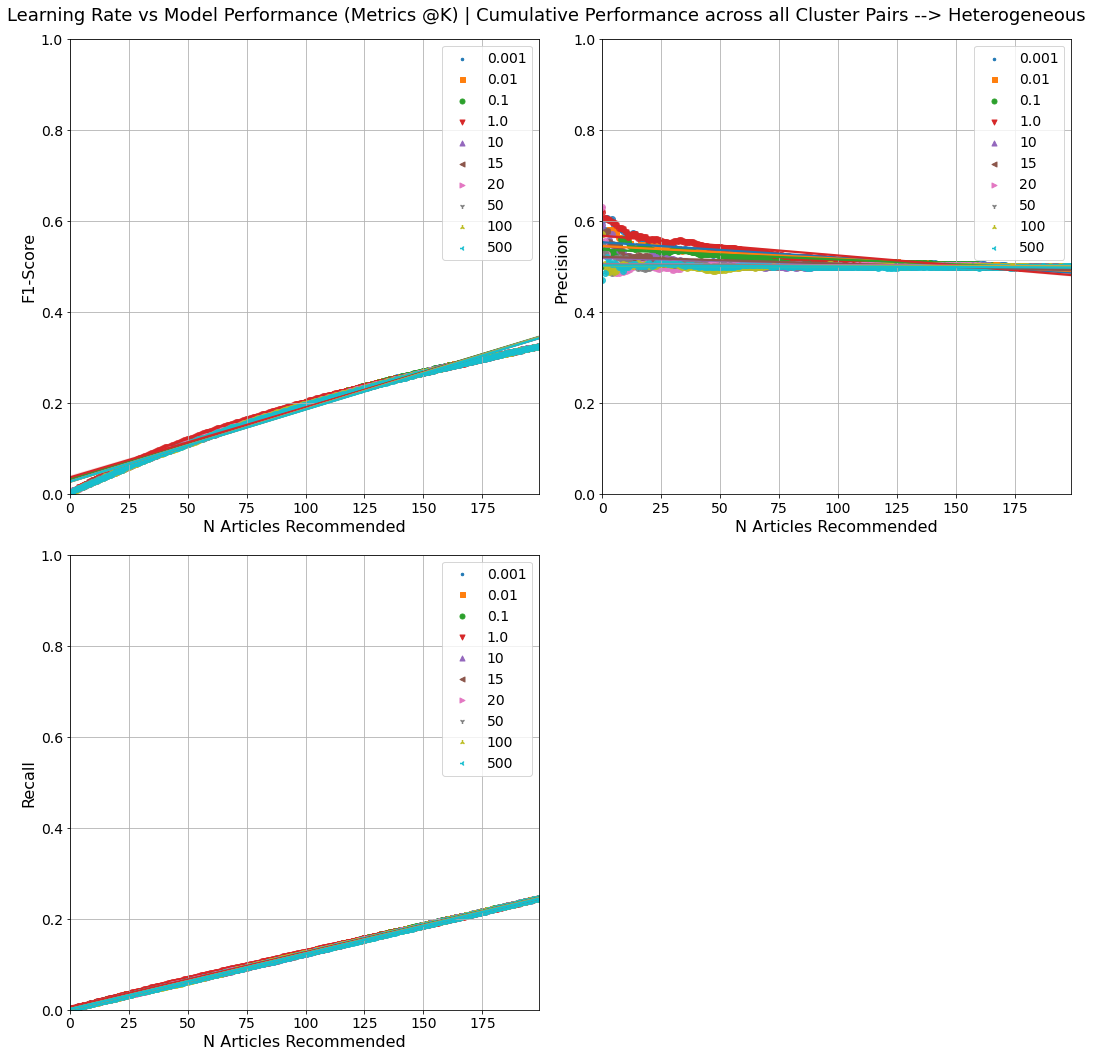


Finished running 'plot_lr_vs_metrics_at_k' in 0.0642 mins


Finished running 'plot_lr_vs_metrics_at_k_cumu' in 0.0649 mins



In [65]:
plot_lr_vs_metrics_at_k_cumu(hetero_scores,
                             lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mixed_data=True)

In [66]:
#  plot_mixed_data_all_cp_precis_lr(scores_=homo_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Homogeneous",metric="precision")

In [67]:
#  plot_mixed_data_all_cp_precis_lr(scores_=hetero_scores,
#                              lr=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],
#                              user_type="Heterogeneous",metric="precision")

In [68]:
homo_param_res = calculate_avg_precision_param_variation(homo_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [69]:
calculate_map_param_variation(homo_param_res,mode="mixed")


Param : 0.001
0.6322475414978538
c1 MAP : 
0.6399403472992319
c2 MAP : 
0.6173850582213518

Param : 0.01
0.6264406689431528
c1 MAP : 
0.6346461500464085
c2 MAP : 
0.6109073071662642

Param : 0.1
0.6187313575667052
c1 MAP : 
0.6256274499226765
c2 MAP : 
0.6073260314731792

Param : 1.0
0.5701794332313829
c1 MAP : 
0.5712599842343554
c2 MAP : 
0.5618370459475307

Param : 10
0.5113513516562198
c1 MAP : 
0.5082619787841742
c2 MAP : 
0.5077621192173088

Param : 15
0.4945383543957266
c1 MAP : 
0.4927553757340518
c2 MAP : 
0.49103718876869573

Param : 20
0.4984871201815515
c1 MAP : 
0.4885558537018965
c2 MAP : 
0.5020616596805867

Param : 50
0.5021404916918155
c1 MAP : 
0.5035039335857872
c2 MAP : 
0.49647029323399416

Param : 100
0.5020852483752932
c1 MAP : 
0.5040197275223978
c2 MAP : 
0.49573815710855795

Param : 500
0.500448905940939
c1 MAP : 
0.49948634714975115
c2 MAP : 
0.49453105768382094


In [70]:
hetero_param_res = calculate_avg_precision_param_variation(hetero_scores,
                                                         params=[0.001,0.01,0.1,1.0,10,15,20,50,100,500],mode="mixed")

In [71]:
calculate_map_param_variation(hetero_param_res,mode="mixed")


Param : 0.001
0.5192986960905718
c1 MAP : 
0.6467547536239512
c2 MAP : 
0.366569813670433

Param : 0.01
0.5169784723994482
c1 MAP : 
0.6381222668399272
c2 MAP : 
0.37167349342143347

Param : 0.1
0.5150299348302304
c1 MAP : 
0.6297572009927213
c2 MAP : 
0.37905398172667126

Param : 1.0
0.5239678632989547
c1 MAP : 
0.5878868415625862
c2 MAP : 
0.4445579409994825

Param : 10
0.5053152638912995
c1 MAP : 
0.5030530074807146
c2 MAP : 
0.49854682903819997

Param : 15
0.506070739323672
c1 MAP : 
0.5107786327332381
c2 MAP : 
0.49590960897782893

Param : 20
0.5021871987762883
c1 MAP : 
0.5020969527729242
c2 MAP : 
0.49828815478048244

Param : 50
0.5011269416623866
c1 MAP : 
0.4944530203049304
c2 MAP : 
0.5031178409920684

Param : 100
0.500288976775052
c1 MAP : 
0.4939296813225681
c2 MAP : 
0.49971261498272423

Param : 500
0.49958559200225383
c1 MAP : 
0.5023004530536768
c2 MAP : 
0.49203236605640227
